#  Train CNN models for detecting particles

## Train the model from scratch using synthetic and experimental data 

1. This section is for inistial training loop (synthetic and experimental data) 
2. The training loop , validation and visualization are kept in the helper_train_.py file  

In [1]:
# ................ import some modules ................
import os
from pathlib import Path
import logging
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Build the package 
!pip install -e ".."

Obtaining file:///C:/Users/tosam/OneDrive/Desktop/Codes/CNN_object_detection/Project
  Attempting uninstall: cnn-semi-supervised
    Found existing installation: cnn-semi-supervised 1.2
    Uninstalling cnn-semi-supervised-1.2:
      Successfully uninstalled cnn-semi-supervised-1.2
  Running setup.py develop for cnn-semi-supervised


In [6]:
# ........ import the user-defined modules ............
# imports the training data loading pipeline 
from data_funnel import ParticleDataset

# imports the CNN models
from models import UNetHeatmap

# imports the device check, training code and
from helper_train_ import get_nvidia_info, train_model

# import general utility modules 

from utils.logger_utils import setup_logger
from utils.GPU_check_utils import get_nvidia_info
from utils.visualizations import visualize

In [4]:
# get the path to the script directory
cwd = Path().resolve() 
setup_logger(str(root), exp_name="Run_1", log_to_console=False)

'Run_1_2025-06-11_23-15-33.log'

In [5]:
# check the GPU status and being detected correctly.
get_nvidia_info()

In [ ]:
class training_setup: 
    
    def __init__(self):
        

In [10]:
if __name__ == "__main__":
    
    try : 
        logging.info('............ Started Training Setup ...............')
        img_dir = str(root.parent.parent /'Imagefolder_100')
        heatmap_dir = str(root.parent.parent /'HeatmapFolder_100')

        # Sort to ensure matching order (assuming same file names)
        img_paths = sorted(glob.glob(img_dir+ '\*.png'))
        heatmap_paths = sorted(glob.glob(heatmap_dir+ '\*.npy'))

        # Pair them together
        pairs = list(zip(img_paths, heatmap_paths))

        # Train/val/test split
        train_pairs, temp_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
        val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

        # Create datasets ... training, validation and test datasets .... 
        train_dataset = ParticleDataset(np.array(train_pairs).T[0], np.array(train_pairs).T[1])
        val_dataset = ParticleDataset(np.array(val_pairs).T[0], np.array(val_pairs).T[1])
        test_dataset = ParticleDataset(np.array(test_pairs).T[0], np.array(test_pairs).T[1])

        # Create the loaders
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
 
        # Model instatiation
        model = UNetHeatmap()
        epochs = 1
        lr = 1e-03
        
        # save info in the log
        logging.info(f"Training started for model: {model.__class__.__name__}")
        logging.info(f"Number of epochs: {epochs}")
        logging.info(f"Learning rate: {lr}")
        
        # start the training operations
        logging.info('....... Model loaded and starting the training ..........')
        model = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr)
        
        # catch the error in case there is a training failure ..... @ Samadarshi added the log file thingy. 
    except Exception as e:
        logging.error(f".......The training failed || Error --->: {e}")     

Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:20<00:00, 24.17it/s]


Epoch 1/1 || Train Loss: 0.0002 || Val Loss: 0.0000


### Visualise the model prediction

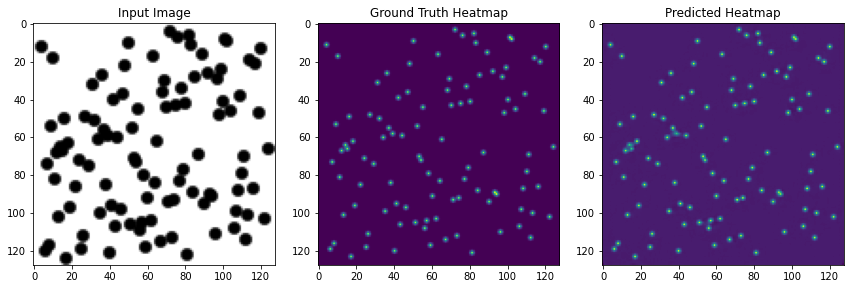

In [11]:
# Visualize
visualize(model, val_dataset, index=0)

In [ ]:
# for keeping the checkpoint ...make a class for this  ..... 
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "checkpoint.pth")

checkpoint = torch.load("checkpoint.pth", map_location=device)
model = MyModel(*args, **kwargs)
optimizer = torch.optim.Adam(model.parameters(), lr=new_lr)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint.get('epoch', 0)
model.train()

In [30]:
# save the model and the state dict 

torch.save(model, str(root / 'CNN_UNET_full_model.pth'))
torch.save(model.state_dict(),str(root / 'CNN_UNET_full_model_state_dict.pth'))

## Now for the human-in-loop step after improving the labels via ImageJ

In [31]:
# now load the model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cycle = UNetHeatmap().to(device)
state_dict = torch.load(str(root / 'CNN_UNET_full_model_state_dict.pth'), map_location=device)
model_cycle.load_state_dict(state_dict)

<All keys matched successfully>

Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.41it/s]


Epoch 1/1 || Train Loss: 0.0000 || Val Loss: 0.0000


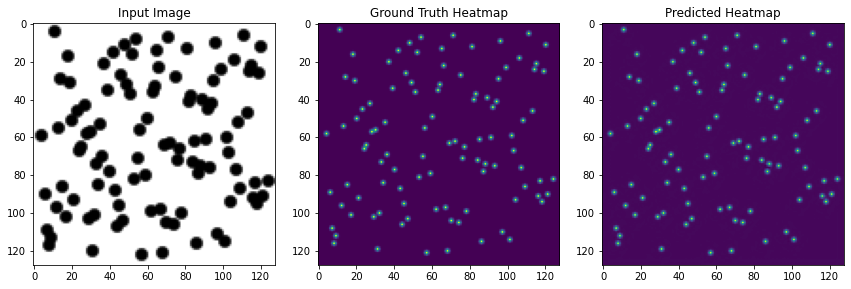

In [36]:
if __name__ == "__main__":
    
    try : 
        logging.info('............  Training with corrected labels ...............')
        img_dir = str(root.parent.parent /'Imagefolder_100')
        heatmap_dir = str(root.parent.parent /'HeatmapFolder_100')

        # Sort to ensure matching order (assuming same file names)
        img_paths = sorted(glob.glob(img_dir+ '\*.png'))
        heatmap_paths = sorted(glob.glob(heatmap_dir+ '\*.npy'))

        # Pair them together
        pairs = list(zip(img_paths, heatmap_paths))

        # Train/val/test split
        train_pairs, temp_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
        val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

        # Create datasets ... training, validation and test datasets .... 
        train_dataset = ParticleDataset(np.array(train_pairs).T[0], np.array(train_pairs).T[1])
        val_dataset = ParticleDataset(np.array(val_pairs).T[0], np.array(val_pairs).T[1])
        test_dataset = ParticleDataset(np.array(test_pairs).T[0], np.array(test_pairs).T[1])

        # Create the loaders
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
 
        # Model instatiation
        model = UNetHeatmap()
        epochs = 1
        lr = 1e-03
        
        # save info in the log
        logging.info(f"Training started for model: {model.__class__.__name__}")
        logging.info(f"Number of epochs: {epochs}")
        logging.info(f"Learning rate: {lr}")
        
        # start the training operations
        logging.info('....... Model loaded and starting the training ..........')
        model = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr)
        
        # catch the error in case there is a training failure ..... @ Samadarshi added the log file thingy. 
    except Exception as e:
        logging.error(f".......The training failed || Error --->: {e}")     